#
Download the text file with list of dates

In [118]:
import requests as r
from datetime import datetime
import os
import requests
from netrc import netrc
import urllib3
urllib3.disable_warnings()
import json
import numpy as np
import pandas as pd

from shapely.geometry import Polygon
import geopandas as gp
import argparse
import sys
import warnings
warnings.filterwarnings("ignore")



In [119]:



def gedi_finder(product, polygon):
    
    # Define the base CMR granule search url, including LPDAAC provider name and max page size (2000 is the max allowed)
    cmr = "https://cmr.earthdata.nasa.gov/search/granules.json?pretty=true&provider=LPDAAC_ECS&page_size=2000&concept_id="

    # Set up dictionary where key is GEDI shortname + version
    concept_ids = {'GEDI01_B.002': 'C1908344278-LPDAAC_ECS', 
                   'GEDI02_A.002': 'C1908348134-LPDAAC_ECS', 
                   'GEDI02_B.002': 'C1908350066-LPDAAC_ECS'}

    # CMR uses pagination for queries with more features returned than the page size
    page = 1
    polygon = polygon.replace(' ', '')  # remove any white spaces
    try:
        # Send GET request to CMR granule search endpoint w/ product concept ID, bbox & page number, format return as json
        cmr_response = r.get(f"{cmr}{concept_ids[product]}&polygon[]={polygon}&pageNum={page}").json()['feed']['entry']

        # If 2000 features are returned, move to the next page and submit another request, and append to the response
        while len(cmr_response) % 2000 == 0:
            page += 1
            cmr_response += r.get(f"{cmr}{concept_ids[product]}&polygon[]={polygon}&pageNum={page}").json()['feed']['entry']

        # CMR returns more info than just the Data Pool links, below use list comprehension to return a list of DP links
        return [c['links'][0]['href'] for c in cmr_response]
    except:
        # If the request did not complete successfully, print out the response from CMR
        print(r.get(f"{cmr}{concept_ids[product]}&polygon[]={polygon.replace(' ', '')}&pageNum={page}").json())


In [120]:
product = 'GEDI02_A.002'   
        # Options include 'GEDI01_B.002', 'GEDI02_A.002', 'GEDI02_B.002'
#polygon = '80.0784735131836,20.651559586927647,80.49666351318359,20.65155958692764,80.50764083862305,20.85327751618467,80.0784735131836,20.842896187484477,80.0784735131836,20.651559586927647' # bounding box coordinates in LL Longitude, LL Latitude, UR Longitude, UR Latitude format
#bbox = '80.06583645229416,20.863380483085145,80.06583645229416,20.632219021164705,80.51627590541916,20.632219021164705,80.51627590541916,20.863380483085145,80.06583645229416,20.863380483085145'

bbox = '72.75006444954514, 22.78874298462253, 72.75006444954514, 22.495624127393626, 74.95115298423937,\
      22.495624127393626, 74.95115298423937, 22.78874298462253,72.75006444954514, 22.78874298462253' 



granules = gedi_finder(product, bbox)
print(f"{len(granules)} {product} Version 2 granules found.")

# Set up output text file name using the current datetime
outName = f"{product.replace('.', '_')}_GranuleList_{datetime.now().strftime('%Y%m%d%H%M%S')}.txt"

# Open file and write each granule link on a new line
with open(outName, "w") as gf:
    for g in granules:
        gf.write(f"{g}\n")
        # if date in g:
        #    url =g
print(f"File containing links to intersecting {product} Version 2 data has been saved to:\n {os.getcwd()}\{outName}")

264 GEDI02_A.002 Version 2 granules found.
File containing links to intersecting GEDI02_A.002 Version 2 data has been saved to:
 c:\Users\tanya\Desktop\GEDI\GEDI02_A_002_GranuleList_20230523105948.txt


# Login into the NASA account

In [121]:
dates = ['2022.03','2022.04']


with open(outName,'r') as f:
    lines = f.readlines()

urls = []
for i in lines:
    for j in dates:
        if j == str(i.split('/')[7][:7]):
            urls.append(i)


In [122]:
urls

['https://e4ftl01.cr.usgs.gov//GEDI_L1_L2/GEDI/GEDI02_A.002/2022.03.21/GEDI02_A_2022080112226_O18526_02_T08424_02_003_03_V002.h5\n',
 'https://e4ftl01.cr.usgs.gov//GEDI_L1_L2/GEDI/GEDI02_A.002/2022.03.25/GEDI02_A_2022084094738_O18587_02_T00039_02_003_02_V002.h5\n',
 'https://e4ftl01.cr.usgs.gov//GEDI_L1_L2/GEDI/GEDI02_A.002/2022.03.29/GEDI02_A_2022088081231_O18648_02_T10306_02_003_02_V002.h5\n',
 'https://e4ftl01.cr.usgs.gov//GEDI_L1_L2/GEDI/GEDI02_A.002/2022.04.02/GEDI02_A_2022092063656_O18709_02_T04920_02_003_02_V002.h5\n',
 'https://e4ftl01.cr.usgs.gov//GEDI_L1_L2/GEDI/GEDI02_A.002/2022.04.03/GEDI02_A_2022093150652_O18730_03_T07022_02_003_02_V002.h5\n',
 'https://e4ftl01.cr.usgs.gov//GEDI_L1_L2/GEDI/GEDI02_A.002/2022.04.06/GEDI02_A_2022096050052_O18770_02_T05379_02_003_02_V002.h5\n',
 'https://e4ftl01.cr.usgs.gov//GEDI_L1_L2/GEDI/GEDI02_A.002/2022.04.07/GEDI02_A_2022097133039_O18791_03_T04482_02_003_02_V002.h5\n',
 'https://e4ftl01.cr.usgs.gov//GEDI_L1_L2/GEDI/GEDI02_A.002/2022.04.1

In [123]:
# urs = 'urs.earthdata.nasa.gov'    # Earthdata URL to call for authentication
# prompts = ['Enter NASA Earthdata Login Username \n(or create an account at urs.earthdata.nasa.gov): ',
#            'Enter NASA Earthdata Login Password: ']

# # Determine if netrc file exists, and if so, if it includes NASA Earthdata Login Credentials
# try:
#     netrcDir = os.path.expanduser("~/.netrc")
#     netrc(netrcDir).authenticators(urs)[0]

# # Below, create a netrc file and prompt user for NASA Earthdata Login Username and Password
# except FileNotFoundError:
#     homeDir = os.path.expanduser("~")
#     Popen('touch {0}.netrc | chmod og-rw {0}.netrc | echo machine {1} >> {0}.netrc'.format(homeDir + os.sep, urs), shell=True)
#     Popen('echo login {} >> {}.netrc'.format(getpass(prompt=prompts[0]), homeDir + os.sep), shell=True)
#     Popen('echo password {} >> {}.netrc'.format(getpass(prompt=prompts[1]), homeDir + os.sep), shell=True)

# # Determine OS and edit netrc file if it exists but is not set up for NASA Earthdata Login
# except TypeError:
#     homeDir = os.path.expanduser("~")
#     Popen('echo machine {1} >> {0}.netrc'.format(homeDir + os.sep, urs), shell=True)
#     Popen('echo login {} >> {}.netrc'.format(getpass(prompt=prompts[0]), homeDir + os.sep), shell=True)
#     Popen('echo password {} >> {}.netrc'.format(getpass(prompt=prompts[1]), homeDir + os.sep), shell=True)

# download the file

In [124]:


saveDir = './da/'

urs = 'urs.earthdata.nasa.gov' 
netrcDir = os.path.expanduser("~/.netrc")
netrc(netrcDir).authenticators(urs)[0]


for f in urls:
    if not os.path.exists(saveDir):
            os.makedirs(saveDir)
    saveName = os.path.join(saveDir, f.split('/')[-1].strip())

        # Create and submit request and download file
    with requests.get(f.strip(), verify=False, stream=True, auth=(netrc(netrcDir).authenticators(urs)[0], netrc(netrcDir).authenticators(urs)[2])) as response:
        if response.status_code != 200:
            print("{} not downloaded. Verify that your username and password are correct in {}".format(f.split('/')[-1].strip(), netrcDir))
        else:
            response.raw.decode_content = True
            content = response.raw
        # print(content)
            with open(saveName, 'wb') as d:
                while True:
                    chunk = content.read(16 * 1024)
                # print(chunk)
                    if not chunk:
                        break
                    d.write(chunk)
            print('Downloaded file: {}'.format(saveName))
    #time.sleep(1.0)

KeyboardInterrupt: 

# use python GEDI_Subsetter.py --dir testing --roi map.geojson to convert h5 file into geojson

In [ ]:
!python GEDI_Subsetter.py --dir da/april --roi map_adani2.geojson

                                            geometry
0  POLYGON ((72.75006 22.78874, 72.75006 22.49562...
Processing file: GEDI02_A_2022092063656_O18709_02_T04920_02_003_02_V002.h5 (1/6)
Processing 1 of 120: BEAM0000/degrade_flag
Processing 2 of 120: BEAM0000/delta_time
Processing 3 of 120: BEAM0000/digital_elevation_model
Processing 4 of 120: BEAM0000/digital_elevation_model_srtm
Processing 5 of 120: BEAM0000/elev_lowestmode
Processing 6 of 120: BEAM0000/elevation_bias_flag
Processing 7 of 120: BEAM0000/num_detectedmodes
Processing 8 of 120: BEAM0000/quality_flag
Processing 9 of 120: BEAM0000/rh
Processing 10 of 120: BEAM0000/rx_assess/quality_flag
Processing 11 of 120: BEAM0000/selected_algorithm
Processing 12 of 120: BEAM0000/sensitivity
Processing 13 of 120: BEAM0000/shot_number
Processing 14 of 120: BEAM0000/solar_elevation
Processing 15 of 120: BEAM0000/surface_flag
Processing 16 of 120: BEAM0001/degrade_flag
Processing 17 of 120: BEAM0001/delta_time
Processing 18 of 120: BEAM000

In [48]:
import os
import json
april_lat = []
april_lon = []
april_height_95 = []
april_height_99 =[]
april_degrade_flag = []
april_quality_flag = []


for ii in os.listdir('./da/'):
    if 'april' in ii and ii.endswith('.geojson'):
        file_ = './da/' + ii


        with open(file_, 'r') as f:
            data = json.load(f)

        print(len(data['features']))
        # Extract the necessary data fields
    


        for i in range(len(data['features'])):

            april_lat.append(data['features'][i]['properties']['Latitude'])
            april_lon.append(data['features'][i]['properties']['Longitude'])
            april_height_95.append(data['features'][i]['properties']['rh_95'])
            april_height_99.append(data['features'][i]['properties']['rh_99'])
            april_degrade_flag.append(data['features'][i]['properties']['degrade_flag'])
            april_quality_flag.append(data['features'][i]['properties']['quality_flag'])


5843
521
4181
5851
5869
5872


In [49]:
march_lat = []
march_lon = []
march_height_95 = []
march_height_99 =[]
march_degrade_flag =[]
march_quality_flag =[]


for ii in os.listdir('./da/'):
    if 'march' in ii and ii.endswith('.geojson'):
        file_ = './da/' + ii


        with open(file_, 'r') as f:
            data = json.load(f)

        print(len(data['features']))
        # Extract the necessary data fields
    


        for i in range(len(data['features'])):

            march_lat.append(data['features'][i]['properties']['Latitude'])
            march_lon.append(data['features'][i]['properties']['Longitude'])
            march_height_95.append(data['features'][i]['properties']['rh_95'])
            march_height_99.append(data['features'][i]['properties']['rh_99'])
            march_degrade_flag.append(data['features'][i]['properties']['degrade_flag'])
            march_quality_flag.append(data['features'][i]['properties']['quality_flag'])


5852
5872
5857


In [ ]:
len(april_lat)

28137

In [50]:
import rasterio
import numpy as np
import pandas as pd

rowcols_april = []


with rasterio.open('./da/adani_april/B1.tif') as src:
    meta = src.meta
    #print(src.shape);
    for x,y in zip(april_lon,april_lat):
    # Use the transform in the metadata and your coordinates
    
        rowcol = rasterio.transform.rowcol(meta['transform'], xs=x, ys=y)
        rowcols_april.append(rowcol)
        #print(rowcol)


rowcols_march = []


with rasterio.open('./da/adani_march/B1.tif') as src:
    meta = src.meta
    #print(src.shape);
    for x,y in zip(march_lon,march_lat):
    # Use the transform in the metadata and your coordinates
    
        rowcol = rasterio.transform.rowcol(meta['transform'], xs=x, ys=y)
        rowcols_march.append(rowcol)
        #print(rowcol)

## Visualize the extracted data points from lat lons

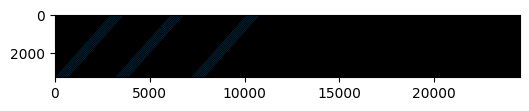

In [52]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Circle

# Get an example image
import matplotlib.cbook as cbook
image_file ='./da/adani_april/B1.tif'
img = plt.imread(image_file)


# Create a figure. Equal aspect so circles look circular
fig,ax = plt.subplots(1)
ax.set_aspect('equal')

# Show the image
ax.imshow(img)

# Now, loop through coord arrays, and create a circle at each x,y pair
# for xx,yy in zip(x,y):

# Now, loop through coord arrays, and create a circle at each x,y pair
for xx in zip(rowcols_march):
    circ = Circle((xx[0][1],xx[0][0]),5)
    ax.add_patch(circ)


# Show the image
plt.show()

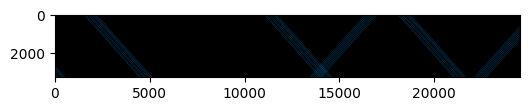

In [51]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Circle

# Get an example image
import matplotlib.cbook as cbook
image_file ='./da/adani_march/B1.tif'
img = plt.imread(image_file)


# Create a figure. Equal aspect so circles look circular
fig,ax = plt.subplots(1)
ax.set_aspect('equal')

# Show the image
ax.imshow(img)

# Now, loop through coord arrays, and create a circle at each x,y pair
# for xx,yy in zip(x,y):

# Now, loop through coord arrays, and create a circle at each x,y pair
for xx in zip(rowcols_april):
    circ = Circle((xx[0][1],xx[0][0]),5)
    ax.add_patch(circ)


# Show the image
plt.show()

In [140]:
print(len(rowcols_april))
print(len(rowcols_march))

28137
17581


In [100]:


def get_values_in_radius(matrix, center, radius,name):
    
    row_end = center[0]+radius+1
    if row_end>matrix.shape[0]:
        row_end = matrix.shape[0]-1

    row_start = center[0]-radius -1
    if row_start<0:
        row_start= 0 
    
    col_end = center[1]+radius +1
    if col_end>matrix.shape[1]-1:
        col_end = matrix.shape[1]- 1

    col_start = center[1]-radius -1
    if col_start<0:
        col_start = 0

 
    c = matrix[center[0]][center[1]]
   
    vv=np.issubdtype(c, np.integer)
    #print(vv)
    if vv:
    
        matrix[center[0]][center[1]]=np.int64(-31082)
        sub_mat = matrix[row_start:row_end+1,col_start:col_end+1]
        #print(sub_mat.shape)
        ind = np.where(sub_mat == np.int64(-31082))

    else:
        matrix[center[0]][center[1]]=-99999
        sub_mat = matrix[row_start:row_end+1,col_start:col_end+1]
        #print(sub_mat.shape)
        ind = np.where(sub_mat == -99999)
    new_center_x = ind[0][0]
    new_center_y = ind[1][0]
    sub_mat[new_center_x][new_center_y]=c

    values_in_radius = []
    for i in range(sub_mat.shape[0]):
        for j in range(sub_mat.shape[1]):
            dist = np.sqrt((i-new_center_x)**2 + (j-new_center_y)**2)
            if dist <= radius:
                values_in_radius.append(sub_mat[i,j])
    return values_in_radius
   

In [106]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Circle
import statistics
# Get an example image
import matplotlib.cbook as cbook
from PIL import Image
from osgeo import gdal


diff_files=['elevation.tif','slope.tif','forestCover.tif']
band_col = {}
files_ = os.listdir('./da/adani_april/')
for fi in files_ :
    
    if  fi!= 'forestCover.tif':
        #continue
        print(fi)
        
        stats ={}
        image_file ='./da/adani_april/{}'.format(fi)
        step1 = gdal.Open(image_file)
        GT_input = step1.GetGeoTransform()
        step2 = step1.GetRasterBand(1)
        img_as_array = step2.ReadAsArray()
       # print(img_as_array.shape)
        medians = []
        means = []
        
        percentile50 = []
        percentile75 = []
        percentile95 = []
        
        i =0
        for xx in zip(rowcols_april):
            
            vals = get_values_in_radius(img_as_array, (xx[0][0],xx[0][1]), 1,i)

            median = statistics.median(vals)
            mean = statistics.mean(vals)
            perc_50 = np.percentile(vals, 50)
            perc_75 = np.percentile(vals, 75)
            perc_95 = np.percentile(vals, 95)    
                
            percentile50.append(perc_50)
            percentile75.append(perc_75)
            percentile95.append(perc_95)
            medians.append(median)
            means.append(mean)

            i+=1
            

        
        stats['mean']=means
        stats['median'] = medians
        stats['50p'] = percentile50
        stats['75p'] = percentile75
        stats['95p'] = percentile95


        band_col[fi.split('.')[0]] = stats

    elif fi == 'forestCover.tif':
        vals=[]
        image_file ='./da/adani_april/{}'.format(fi)
        step1 = gdal.Open(image_file)
        GT_input = step1.GetGeoTransform()
        step2 = step1.GetRasterBand(1)
        img_as_array = step2.ReadAsArray()

      
        for xx in zip(rowcols_april):
            # vals = get_values_in_radius(img_as_array, (xx[0][0],xx[0][1]), 2,i)
            # print(vals)
            n_rows = (xx[0][0]-1,min((xx[0][0]+2),img_as_array.shape[0]-1))
            m_cols = (xx[0][1]-1,min((xx[0][1]+2),img_as_array.shape[1]-1))
            # val = img_as_array[xx[0][0]][xx[0][1]]
            # vals.append(val)
            nbrs =0
            for n in range(n_rows[0],n_rows[1]):
                for m in range(m_cols[0],m_cols[1]):
                    if img_as_array[n][m] ==10:
                        nbrs+=1
            if nbrs>=6:

                vals.append(10)
            else:
                vals.append(0)
            print(nbrs)
        band_col[fi.split('.')[0]] = vals




B1.tif
B11.tif
B12.tif
B2.tif
B3.tif
B4.tif
B5.tif
B6.tif
B7.tif
B8.tif
B8A.tif
B9.tif
elevation.tif
6
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
0
9
9
9
9
3
9
9
0
0
1
4
9
9
0
0
9
9
9
9
9
9
0
9
3
6
9
5
0
9
0
6
9
9
6
0
9
1
0
3
1
9
9
3
3
9
9
8
9
9
9
9
9
7
9
9
3
9
9
9
9
5
0
2
5
9
9
9
4
3
9
9
7
9
4
7
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
9
8
4
0
0
0
0
0
0
0
0
0
0
6
9
8
0
6
5
1
0
0
0
0
0
0
0
0
7
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
8
9
9
9
9
9
9
9
9
9
8
9
9
9
9
9
9
9
9
9
9
9
6
8
0
5
9
8
9
9
9
9
9
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
1
0
3
0
0
0
0
7
0
1
0
0
0
0
0
0
0
0
0
0
6
7
0
0
0
3
0
0
1
2
0
6
0
0
0
0
0
0
0
0
0
0
0
3
9
9
9
0
0
0
0
7
3
5
0
5
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
5
9
9
9
7
9
9
4
5
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
3
9
6
0
0
0
0
0
0
0
0
0
0
0
0
0
0
9
0
0
0
0
0
0
0
0
0
0
0
0
4
3
1
4
4
1
3
0
0
1
0
0
0
2
0
0
0
0
0
8
0
0
0
0
0
0
1
0
0
1
8
2
7
6
0
0
9
9
9
9
8
8
0
0
0
0
0
0
0
0
0
0
0
0
0
6
0
0
0
0
0
0
0
0
0
0
0
0
9
9
3
7
1
3
9
3
0
6
9

In [107]:
coord = zip(april_lat,april_lon)
pixelval = rowcols_april
# rh_95 = height

df = pd.DataFrame({'coord':coord,'pixelVal':pixelval,'rh_95':april_height_95,'rh_99':april_height_99,'degrade_flag':april_degrade_flag,\
                   'quality_flag':april_quality_flag})

for band in band_col.keys():
    if band!= 'forestCover':
        for metric in band_col[band].keys():
            df[band+'_'+metric] = band_col[band][metric]
    else:
        df['forestMask'] = band_col['forestCover']

df.to_csv('./april_adani_new.csv')

In [108]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Circle
import statistics
# Get an example image
import matplotlib.cbook as cbook
from PIL import Image
from osgeo import gdal


diff_files=['elevation.tif','slope.tif','forestCover.tif']
band_col = {}
files_ = os.listdir('./da/adani_march/')
for fi in files_ :
    
    if  fi!= 'forestCover.tif':
        print(fi)
        
        stats ={}
        image_file ='./da/adani_march/{}'.format(fi)
        step1 = gdal.Open(image_file)
        GT_input = step1.GetGeoTransform()
        step2 = step1.GetRasterBand(1)
        img_as_array = step2.ReadAsArray()
       # print(img_as_array.shape)
        medians = []
        means = []
        
        percentile50 = []
        percentile75 = []
        percentile95 = []
        
        i =0
        for xx in zip(rowcols_march):
            
            vals = get_values_in_radius(img_as_array, (xx[0][0],xx[0][1]), 1,i)

            median = statistics.median(vals)
            mean = statistics.mean(vals)
            perc_50 = np.percentile(vals, 50)
            perc_75 = np.percentile(vals, 75)
            perc_95 = np.percentile(vals, 95)    
                
            percentile50.append(perc_50)
            percentile75.append(perc_75)
            percentile95.append(perc_95)
            medians.append(median)
            means.append(mean)

            i+=1
            

        
        stats['mean']=means
        stats['median'] = medians
        stats['50p'] = percentile50
        stats['75p'] = percentile75
        stats['95p'] = percentile95


        band_col[fi.split('.')[0]] = stats

    elif fi == 'forestCover.tif':
        vals=[]
        image_file ='./da/adani_march/{}'.format(fi)
        step1 = gdal.Open(image_file)
        GT_input = step1.GetGeoTransform()
        step2 = step1.GetRasterBand(1)
        img_as_array = step2.ReadAsArray()

      
        for xx in zip(rowcols_march):
            # vals = get_values_in_radius(img_as_array, (xx[0][0],xx[0][1]), 2,i)
            # print(vals)
            n_rows = (xx[0][0]-1,min((xx[0][0]+2),img_as_array.shape[0]-1))
            m_cols = (xx[0][1]-1,min((xx[0][1]+2),img_as_array.shape[1]-1))
            # val = img_as_array[xx[0][0]][xx[0][1]]
            # vals.append(val)
            nbrs =0
            for n in range(n_rows[0],n_rows[1]):
                for m in range(m_cols[0],m_cols[1]):
                    if img_as_array[n][m] ==10:
                        nbrs+=1
            if nbrs>=6:

                vals.append(10)
            else:
                vals.append(0)
            print(nbrs)
        band_col[fi.split('.')[0]] = vals




B1.tif
B11.tif
B12.tif
B2.tif
B3.tif
B4.tif
B5.tif
B6.tif
B7.tif
B8.tif
B8A.tif
B9.tif
elevation.tif
3
0
0
4
0
3
0
0
0
0
0
0
0
0
1
0
8
3
0
0
0
0
0
2
0
0
6
2
0
0
0
0
2
0
0
1
0
2
0
0
0
0
0
0
0
0
8
5
6
0
0
6
1
0
0
0
0
0
0
0
0
5
0
0
0
5
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
9
0
6
6
0
0
0
0
0
0
0
0
0
0
3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
9
0
0
0
5
0
2
8
0
0
0
0
0
0
1
4
0
0
0
2
4
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
1
0
0
0
0
0
7
0
0
0
4
1
0
0
0
0
0
6
0
0
0
0
0
0
0
0
0
0
0
7
4
1
0
0
0
6
0
2
0
3
9
3
1
0
0
0
0
0
0
0
0
0
0
0
0
6
0
0
0
0
2
0
0
1
9
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
9
2
5
4
0
0
1
0
0
0
0
0
0
5
1
0
0
0
0
9
8
4
6
0
0
0
0
0
7
7
3
1
5
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2
3
0
0
0
0
9
6
6
9
2
0
0
0
9
1
8
4
3
6
2
0
0
0
0
0
0
0
1
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
7
0
1
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
9
9
4
0
0
0
0
0
2
0
0
0
0
0
0
9
0
3
0
3
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
3
0
0
1
0
0
0
2
3
8
6
0
1
9
6
8
7
0
3
1
7
7
5
0
0
0
1
9
6
8
6
0
9
8
4
0
0
4
9
5
3
8
7

In [109]:
coord = zip(march_lat,march_lon)
pixelval = rowcols_march
# rh_95 = height

df = pd.DataFrame({'coord':coord,'pixelVal':pixelval,'rh_95':march_height_95,'rh_99':march_height_99,'degrade_flag':march_degrade_flag,\
                   'quality_flag':march_quality_flag})

print(len(df))
for band in band_col.keys():
    if band!= 'forestCover':
        for metric in band_col[band].keys():
            df[band+'_'+metric] = band_col[band][metric]
    else:
        df['forestMask'] = band_col['forestCover']

df.to_csv('./march_adani_new.csv')

17581


In [401]:
import pandas as pd
df_april = pd.read_csv('april_adani_q.csv')
df_march = pd.read_csv('march_adani_q.csv')

frames = [df_april, df_march]
  
df = pd.concat(frames)
print(len(df_april)+len(df_march))
len(df)

45718


45718

In [368]:
df.head()

Unnamed: 0                                    coord       pixelVal  rh_95  \
0           0   (22.49571875261186, 73.95715244626408)  (3262, 13437)  10.54   
1           1   (22.49611598652905, 73.95750292595079)  (3258, 13441)   5.72   
2           2  (22.496508403918142, 73.95784563048663)  (3254, 13444)   9.68   
3           3   (22.496907259806722, 73.9581987101031)  (3249, 13448)   5.64   
4           4   (22.49731037477882, 73.95855865602469)  (3245, 13452)  11.85   

   rh_99  degrade_flag  quality_flag   B1_mean  B1_median   B1_50p  ...  \
0  11.33            80             0  0.150200    0.15015  0.15015  ...   
1   6.54            80             0  0.151869    0.15200  0.15200  ...   
2  10.62            80             0  0.152508    0.15255  0.15255  ...   
3   6.69            80             0  0.152454    0.15285  0.15285  ...   
4  12.71            80             0  0.152827    0.15285  0.15285  ...   

   ndvi_mean  ndvi_median  ndvi_50p  ndvi_75p  ndvi_95p  slope_mean  \
0   0.223757     0.222421  0.222421  0.241848  0.255036    8.212587   
1   0.223711     0.211850  0.211850  0.249911  0.265846   11.750763   
2   0.250090     0.242308  0.242308  0.295903  0.317150    4.689776   
3   0.274102     0.259645  0.259645  0.293420  0.397511   15.038361   
4   0.262427     0.264690  0.264690  0.297269  0.324292   19.066711   

   slope_median  slope_50p  slope_75p  slope_95p  
0      8.347988   8.347988   8.890456  10.517859  
1     11.668093  11.668093  13.237470  13.237470  
2      4.093288   4.093288   5.006632   6.572777  
3     16.923151  16.923151  16.923151  17.543848  
4     18.541391  18.541391  21.150249  21.150249  

[5 rows x 93 columns]

In [402]:
df = df.drop(['Unnamed: 0'],axis = 1)

In [371]:
df.columns

Index(['coord', 'pixelVal', 'rh_95', 'rh_99', 'degrade_flag', 'quality_flag',
       'B1_mean', 'B1_median', 'B1_50p', 'B1_75p', 'B1_95p', 'B11_mean',
       'B11_median', 'B11_50p', 'B11_75p', 'B11_95p', 'B12_mean', 'B12_median',
       'B12_50p', 'B12_75p', 'B12_95p', 'B2_mean', 'B2_median', 'B2_50p',
       'B2_75p', 'B2_95p', 'B3_mean', 'B3_median', 'B3_50p', 'B3_75p',
       'B3_95p', 'B4_mean', 'B4_median', 'B4_50p', 'B4_75p', 'B4_95p',
       'B5_mean', 'B5_median', 'B5_50p', 'B5_75p', 'B5_95p', 'B6_mean',
       'B6_median', 'B6_50p', 'B6_75p', 'B6_95p', 'B7_mean', 'B7_median',
       'B7_50p', 'B7_75p', 'B7_95p', 'B8_mean', 'B8_median', 'B8_50p',
       'B8_75p', 'B8_95p', 'B8A_mean', 'B8A_median', 'B8A_50p', 'B8A_75p',
       'B8A_95p', 'B9_mean', 'B9_median', 'B9_50p', 'B9_75p', 'B9_95p',
       'elevation_mean', 'elevation_median', 'elevation_50p', 'elevation_75p',
       'elevation_95p', 'forestMask', 'gci_mean', 'gci_median', 'gci_50p',
       'gci_75p', 'gci_95p', 'gli_m

In [425]:
import numpy as np

X = df.copy()
# bins = [0,10,16,25 ,np.inf]
# names = ['<10','10-16','16-25','25+']

# X['height_classes'] = pd.cut(X['rh_95'], bins, labels=names)
#[:3*int(len(df)/4)]
#X = X.drop(['coord','pixelVal','rh_99','B1_median'],axis = 1)
X = X.loc[X['forestMask'] == 10]
X = X.loc[X['quality_flag']==1]
X = X.loc[X['degrade_flag']==0]


pps_df = X.copy()
pps_df=X[['B2_median','B3_median','B4_median','B5_mean','gci_mean','ndvi_mean','gli_mean','rh_95']]


# X = X[['B2_mean','B3_mean','B4_mean','B5_mean',\
#        'B8_mean','B9_mean','B8A_mean','B11_mean','B12_mean',\
#         'gci_mean','ndvi_mean','gli_mean','height_classes']]

X = X[['B3_mean','B4_mean','B5_mean','B6_mean','B7_mean',\
       'B8_mean','B9_mean','B8A_mean','B11_mean','B12_mean',\
        'gci_mean','ndvi_mean','gli_mean','elevation_mean','rh_95']]


y = X.pop("rh_95")

target_names = names

# y = X.pop("height_classes")

# X = X[['rh_95','B1_mean','B2_mean','B3_mean','B4_mean','B5_mean','B6_mean','B7_mean',\
#        'B8_mean','B9_mean','B8A_mean','B11_mean','B12_mean','gci_mean','ndvi_mean','gli_mean']]



In [399]:
pps_df

B2_mean   B3_mean   B4_mean   B5_mean  gci_mean  ndvi_mean  gli_mean  \
6015   0.155700  0.187196  0.194315  0.249923  1.125323   0.343187  0.034064   
6089   0.167912  0.196573  0.209681  0.255292  1.026601   0.308910  0.023310   
6100   0.151323  0.182388  0.183704  0.239185  1.283889   0.386018  0.045250   
6111   0.166869  0.198808  0.211123  0.262669  0.985458   0.306122  0.026438   
6162   0.143492  0.171346  0.173212  0.226681  1.473503   0.419652  0.042784   
...         ...       ...       ...       ...       ...        ...       ...   
10002  0.138177  0.162246  0.155596  0.201292  1.349217   0.418529  0.048809   
10007  0.146865  0.174608  0.181081  0.230777  1.334130   0.380901  0.034155   
10014  0.148738  0.173081  0.196615  0.237946  0.874750   0.244560  0.000903   
10059  0.158965  0.184300  0.204512  0.243565  0.861720   0.255535  0.008026   
10110  0.138804  0.161427  0.154481  0.203258  1.174976   0.382667  0.046112   

       rh_95  
6015    9.96  
6089    5.63  
6100    5.74  
6111    6.90  
6162    7.16  
...      ...  
10002  13.46  
10007   9.46  
10014   8.07  
10059   3.62  
10110   9.83  

[2432 rows x 8 columns]

In [417]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## ANN

In [418]:
import torch.nn as nn
# import torch.nn as nn
# model = nn.Sequential(
#     nn.Linear(13, 26),
#     nn.ReLU(),
#     nn.Linear(26, 52),
#     nn.ReLU(),
#     nn.Linear(52, 48),
#     nn.ReLU(),
#     nn.Linear(48, 24),
#     nn.ReLU(),
#     nn.Linear(24, 18),
#     nn.ReLU(),
#     nn.Linear(18, 12),
#     nn.ReLU(),
#     nn.Linear(12, 6),
#     nn.ReLU(),
#     nn.Linear(6, 3),
#     nn.ReLU(),
#     nn.Linear(3, 1)
#     # nn.Linear(12, 1)
# )
# model.load_state_dict(torch.load('./direct_model.pth')) 


model = nn.Sequential(
    nn.Linear(14, 28),
    nn.ReLU(),
    nn.Linear(28, 56),
    nn.ReLU(),
    nn.Linear(56, 48),
    nn.ReLU(),
    nn.Linear(48, 24),
    nn.ReLU(),
    nn.Linear(24, 18),
    nn.ReLU(),
    nn.Linear(18, 12),
    nn.ReLU(),
    nn.Linear(12, 6),
    nn.ReLU(),
    nn.Linear(6, 3),
    nn.ReLU(),
    nn.Linear(3, 1)
   
)
# class CustomLoss(nn.Module):
#     def __init__(self, weight=1):
#         super(CustomLoss, self).__init__()
#         self.weight = weight
#         self.l1_loss = nn.L1Loss()

#     def forward(self, y_true, y_pred):
#         # Calculate the mean L1 loss
#         l1_loss = self.l1_loss(y_pred, y_true)
#         # print('prev loss : ',l1_loss)
#         # Increase the loss for predictions less than 5
#         increased_loss = torch.where(y_true < 5, self.weight * l1_loss, l1_loss)
#         mean_loss = increased_loss.mean()
#         # print('inc loss :',increased_loss)
#         return mean_loss


In [419]:

import torch.nn as nn
import torch.optim as optim
 
# loss function and optimizer
loss_fn = nn.L1Loss()
# model = ANN()
#nn.L1Loss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)


import numpy as np
import torch
import tqdm
from sklearn.model_selection import train_test_split
 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import copy
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)
 
# training parameters
n_epochs = 300   # number of epochs to run
batch_size = 10  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []

# training loop
for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # print progress
            bar.set_postfix(l1=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    l1 = loss_fn(y_pred, y_test)
    l1 = float(l1)
    history.append(l1)
    if l1 < best_mse:
        best_l1 = l1
        best_weights = copy.deepcopy(model.state_dict())
 
# restore model and return best accuracy
model.load_state_dict(best_weights)

<All keys matched successfully>

L1 Loss : 2.97


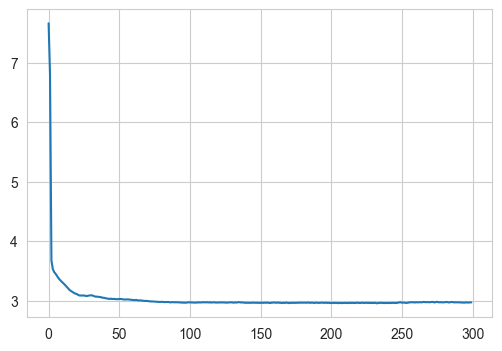

In [420]:
torch.save({'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': best_l1}, 
	    './ann_model3.pth')
torch.save(model.state_dict(), './direct_model3.pth')

import matplotlib.pyplot as plt
print("L1 Loss : %.2f" % best_l1)
# print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

In [437]:
y_pred = model(X_test)

TypeError: 'RandomizedSearchCV' object is not callable

In [422]:
cl_pred =[]
for i in y_pred:
    if i <=6.99:
        cl_pred.append('<6.99')
    elif i>6.99 and i<=13.5:
        cl_pred.append('6.99 - 13.5')
    elif i>13.5 and i<=16.0:
        cl_pred.append('13.5 - 16.0')
    elif i>16.0:
        cl_pred.append('16+')

cl_test =[]
for i in y_test:
    if i <=6.99:
        cl_test.append('<6.99')
    elif i>6.99 and i<=13.5:
        cl_test.append('6.99 - 13.5')
    elif i>13.5 and i<=16.0:
        cl_test.append('13.5 - 16.0')
    elif i>16.0:
        cl_test.append('16+')



In [423]:

right =0
wrong =0
res = list(zip(cl_test,cl_pred))
for idx, (x,y) in enumerate(res):
    if x==y:
        right +=1
    else:
        wrong+=1
print(right,wrong)
    # if idx ==40:
    #     break

141 103


In [344]:

res = list(zip(y_test,y_pred))
for idx, (x,y) in enumerate(res[50:100]):
    print(x,y)
    if idx ==40:
        break

tensor([13.1900]) tensor([7.1641], grad_fn=<UnbindBackward0>)
tensor([3.4700]) tensor([7.1702], grad_fn=<UnbindBackward0>)
tensor([5.0100]) tensor([6.9169], grad_fn=<UnbindBackward0>)
tensor([5.5600]) tensor([7.6107], grad_fn=<UnbindBackward0>)
tensor([13.2600]) tensor([9.5516], grad_fn=<UnbindBackward0>)
tensor([5.3100]) tensor([7.8745], grad_fn=<UnbindBackward0>)
tensor([6.9500]) tensor([7.5527], grad_fn=<UnbindBackward0>)
tensor([8.4900]) tensor([7.4134], grad_fn=<UnbindBackward0>)
tensor([9.4400]) tensor([7.0800], grad_fn=<UnbindBackward0>)
tensor([8.8500]) tensor([7.6472], grad_fn=<UnbindBackward0>)
tensor([4.3700]) tensor([7.4341], grad_fn=<UnbindBackward0>)
tensor([8.9000]) tensor([9.9133], grad_fn=<UnbindBackward0>)
tensor([9.5300]) tensor([9.2199], grad_fn=<UnbindBackward0>)
tensor([7.9900]) tensor([10.1967], grad_fn=<UnbindBackward0>)
tensor([2.3100]) tensor([3.5066], grad_fn=<UnbindBackward0>)
tensor([18.1500]) tensor([8.8037], grad_fn=<UnbindBackward0>)
tensor([2.7200]) ten

## Dimensionality Reduction with important features

[0.56913562 0.92466489]


C:\Users\tanya\AppData\Local\Temp\ipykernel_27316\3853598661.py:19: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x= X_train[y_train == target_names[cl], 0], y= X_train[y_train == target_names[cl], 1],


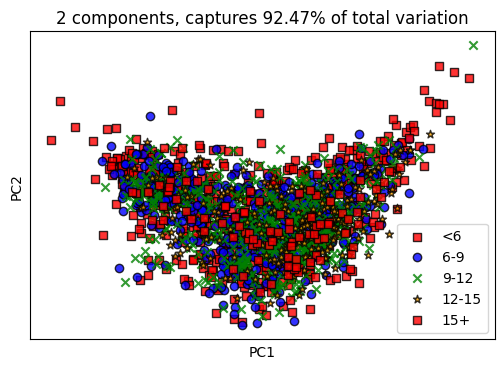

In [258]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

pca = PCA(n_components = 2)
X_train = pca.fit_transform(X_train) 
X_test = pca.transform(X_test) 
cum_explained_variance = np.cumsum(pca.explained_variance_ratio_)
print(cum_explained_variance)
# Scatter plot of data
markers = ('s', 'o', 'x','*','s')
colors = ('red', 'blue', 'green','orange','red')
classes = [0,1,2,3,4]
for idx, cl in enumerate(classes):
    # print(idx,markers[idx])
    # print(cl,target_names[cl])
    # print(y_train,target_names[cl])
    plt.scatter(x= X_train[y_train == target_names[cl], 0], y= X_train[y_train == target_names[cl], 1],
                alpha= 0.8, c= colors[idx],
                
                marker= markers[idx], label= target_names[cl], edgecolor= 'black') 
plt.xlabel('PC1'); plt.xticks([])
plt.ylabel('PC2'); plt.yticks([])
plt.title('2 components, captures {}% of total variation'.format(cum_explained_variance[1].round(4)*100))
plt.legend(loc="lower right")
plt.show() 

## XGB Regressor

In [355]:
from sklearn.model_selection import train_test_split, GridSearchCV
model = xgb.XGBRegressor()

# Define the parameter grid for grid search
param_grid = {
    'max_depth': [3, 4, 5,10],
    'learning_rate': [0.1, 0.01, 0.001,0.0001],
    'n_estimators': [100, 500, 1000,1500]
}

# Perform grid search to find the best parameters
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Get the best model and its hyperparameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Make predictions on the test set using the best model
y_pred = best_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Best Hyperparameters: {best_params}")

Mean Squared Error: 16.447586113377845
Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 500}


In [354]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Best Hyperparameters: {best_params}")

Mean Squared Error: 16.447586113377845
Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 500}


In [ ]:
xgb_random.fit(X_train, y_train)

## Random forest Classifier

In [148]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001E813775DF0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001E810AC4D90>})

In [149]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)


Best hyperparameters: {'max_depth': 15, 'n_estimators': 283}


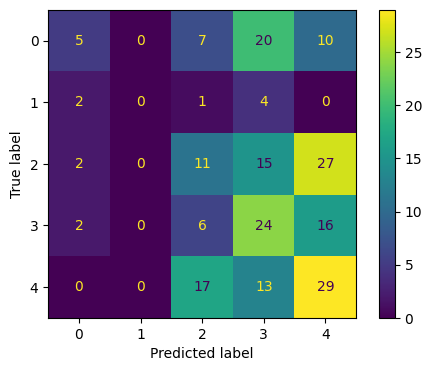

In [150]:
# Generate predictions with the best model
y_pred = best_rf.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

## Extra Tree Regressor to find important features

In [114]:
from sklearn.ensemble import ExtraTreesRegressor
import matplotlib.pyplot as plt
model = ExtraTreesRegressor()
model.fit(X,y)
print(model.feature_importances_)


[0.08404706 0.07556567 0.07955002 0.06934012 0.0678772  0.05923321
 0.05601373 0.06169308 0.06211264 0.05458699 0.08843916 0.06803524
 0.05263813 0.0551259  0.06574185]


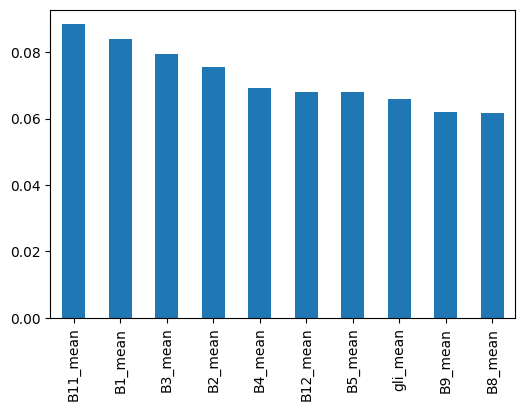

In [115]:
feat_imp = pd.Series(model.feature_importances_,index = X.columns)
feat_imp.nlargest(10).plot(kind='bar')
plt.show()

In [116]:
feats = list(feat_imp.index)
# y = X.pop("rh_95")
X = X[feats]


## Random forest Regressor

In [426]:
from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1)
# print(X_train.shape)
# print(X_test.shape)

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

from sklearn.ensemble import RandomForestRegressor
rf_random = RandomForestRegressor()
import numpy as np
n_estimators = [int(x) for x in np.linspace(start  = 100, stop = 1500, num = 12)]
max_features = ['auto','sqrt']
#max number of levels in a tree
max_depth = [int(x) for x in np.linspace(5,30,num=6)]
#min number of samples required to split a node
min_samples_split = [2,5,10,15,100]
#Min number of samples required at each leaf node
min_samples_leaf = [1,2,5,10]

from sklearn.model_selection import RandomizedSearchCV
random_grid={
    'n_estimators' :n_estimators,
    'max_features' : max_features,
    'max_depth' :max_depth,
    'min_samples_split' :min_samples_split,
    'min_samples_leaf':min_samples_leaf
        
}

rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator= rf, param_distributions= random_grid, scoring='neg_mean_squared_error',n_iter=25, cv = 5, verbose=2, random_state=42, n_jobs=1)

In [427]:
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=1118; total time=   5.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=1118; total time=   5.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=1118; total time=   8.6s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=1118; total time=  10.0s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=1118; total time=   8.9s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1372; total time=  12.9s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1372; total time=  13.5s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_est

c:\Users\tanya\Anaconda3\envs\pygdal38\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=15, max_features=auto, min_samples_leaf=5, min_samples_split=100, n_estimators=354; total time=   5.0s


c:\Users\tanya\Anaconda3\envs\pygdal38\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=15, max_features=auto, min_samples_leaf=5, min_samples_split=100, n_estimators=354; total time=   4.9s


c:\Users\tanya\Anaconda3\envs\pygdal38\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=15, max_features=auto, min_samples_leaf=5, min_samples_split=100, n_estimators=354; total time=   4.7s


c:\Users\tanya\Anaconda3\envs\pygdal38\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=15, max_features=auto, min_samples_leaf=5, min_samples_split=100, n_estimators=354; total time=   4.5s


c:\Users\tanya\Anaconda3\envs\pygdal38\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=15, max_features=auto, min_samples_leaf=5, min_samples_split=100, n_estimators=354; total time=   4.4s


c:\Users\tanya\Anaconda3\envs\pygdal38\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=15, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=481; total time=   8.8s


c:\Users\tanya\Anaconda3\envs\pygdal38\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=15, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=481; total time=   8.9s


c:\Users\tanya\Anaconda3\envs\pygdal38\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=15, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=481; total time=   8.7s


c:\Users\tanya\Anaconda3\envs\pygdal38\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=15, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=481; total time=   9.1s


c:\Users\tanya\Anaconda3\envs\pygdal38\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=15, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=481; total time=   8.9s


c:\Users\tanya\Anaconda3\envs\pygdal38\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=863; total time=  13.6s


c:\Users\tanya\Anaconda3\envs\pygdal38\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=863; total time=  13.3s


c:\Users\tanya\Anaconda3\envs\pygdal38\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=863; total time=  13.9s


c:\Users\tanya\Anaconda3\envs\pygdal38\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=863; total time=  13.9s


c:\Users\tanya\Anaconda3\envs\pygdal38\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=863; total time=  15.6s
[CV] END max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1245; total time=  15.9s
[CV] END max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1245; total time=  16.6s
[CV] END max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1245; total time=  14.9s
[CV] END max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1245; total time=  14.6s
[CV] END max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1245; total time=  13.6s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=15, n_estimators=1372; total time=   4.9s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=15, n_estimators=1372; total time=   4.7s
[CV] END max_depth=5, max_feat

c:\Users\tanya\Anaconda3\envs\pygdal38\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=15, n_estimators=863; total time=  16.9s


c:\Users\tanya\Anaconda3\envs\pygdal38\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=15, n_estimators=863; total time=  17.2s


c:\Users\tanya\Anaconda3\envs\pygdal38\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=15, n_estimators=863; total time=  17.6s


c:\Users\tanya\Anaconda3\envs\pygdal38\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=15, n_estimators=863; total time=  17.1s


c:\Users\tanya\Anaconda3\envs\pygdal38\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=15, n_estimators=863; total time=  16.9s


c:\Users\tanya\Anaconda3\envs\pygdal38\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1500; total time=  22.7s


c:\Users\tanya\Anaconda3\envs\pygdal38\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1500; total time=  22.8s


c:\Users\tanya\Anaconda3\envs\pygdal38\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1500; total time=  22.8s


c:\Users\tanya\Anaconda3\envs\pygdal38\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1500; total time=  21.9s


c:\Users\tanya\Anaconda3\envs\pygdal38\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=25, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1500; total time=  21.8s


c:\Users\tanya\Anaconda3\envs\pygdal38\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=1372; total time=  14.4s


c:\Users\tanya\Anaconda3\envs\pygdal38\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=1372; total time=  14.6s


c:\Users\tanya\Anaconda3\envs\pygdal38\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=1372; total time=  14.5s


c:\Users\tanya\Anaconda3\envs\pygdal38\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=1372; total time=  14.5s


c:\Users\tanya\Anaconda3\envs\pygdal38\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=1372; total time=  14.6s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=736; total time=   6.4s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=736; total time=   6.9s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=736; total time=   7.1s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=736; total time=   6.4s
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=736; total time=   6.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=100, n_estimators=227; total time=   1.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=100, n_estimators=227; total time=   1.2s
[CV] END max_depth=10, max_features=

c:\Users\tanya\Anaconda3\envs\pygdal38\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=481; total time=  10.4s


c:\Users\tanya\Anaconda3\envs\pygdal38\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=481; total time=  10.6s


c:\Users\tanya\Anaconda3\envs\pygdal38\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=481; total time=  10.7s


c:\Users\tanya\Anaconda3\envs\pygdal38\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=481; total time=  10.4s


c:\Users\tanya\Anaconda3\envs\pygdal38\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=481; total time=  10.2s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=1245; total time=   7.2s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=1245; total time=   6.9s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=1245; total time=   6.4s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=1245; total time=   6.4s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=1245; total time=   6.4s


c:\Users\tanya\Anaconda3\envs\pygdal38\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1245; total time=  26.3s


c:\Users\tanya\Anaconda3\envs\pygdal38\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1245; total time=  27.0s


c:\Users\tanya\Anaconda3\envs\pygdal38\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1245; total time=  26.6s


c:\Users\tanya\Anaconda3\envs\pygdal38\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1245; total time=  25.5s


c:\Users\tanya\Anaconda3\envs\pygdal38\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1245; total time=  25.8s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=481; total time=   3.6s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=481; total time=   3.6s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=481; total time=   3.6s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=481; total time=   3.5s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=481; total time=   3.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, n_estimators=990; total time=   4.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=100, n_estimators=990; total time=   4.7s
[CV] END max_depth=10, max_featu

c:\Users\tanya\Anaconda3\envs\pygdal38\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=15, n_estimators=1118; total time=  16.9s


c:\Users\tanya\Anaconda3\envs\pygdal38\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=15, n_estimators=1118; total time=  17.6s


c:\Users\tanya\Anaconda3\envs\pygdal38\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=15, n_estimators=1118; total time=  16.8s


c:\Users\tanya\Anaconda3\envs\pygdal38\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=15, n_estimators=1118; total time=  16.3s


c:\Users\tanya\Anaconda3\envs\pygdal38\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=15, max_features=auto, min_samples_leaf=10, min_samples_split=15, n_estimators=1118; total time=  16.7s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=15, n_estimators=481; total time=   2.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=15, n_estimators=481; total time=   2.3s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=15, n_estimators=481; total time=   2.0s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=15, n_estimators=481; total time=   1.9s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=15, n_estimators=481; total time=   2.1s


c:\Users\tanya\Anaconda3\envs\pygdal38\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1245; total time=  14.1s


c:\Users\tanya\Anaconda3\envs\pygdal38\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1245; total time=  14.3s


c:\Users\tanya\Anaconda3\envs\pygdal38\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1245; total time=  14.5s


c:\Users\tanya\Anaconda3\envs\pygdal38\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1245; total time=  14.0s


c:\Users\tanya\Anaconda3\envs\pygdal38\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1245; total time=  14.1s
[CV] END max_depth=25, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=1118; total time=   7.4s
[CV] END max_depth=25, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=1118; total time=   7.4s
[CV] END max_depth=25, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=1118; total time=   7.4s
[CV] END max_depth=25, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=1118; total time=   7.3s
[CV] END max_depth=25, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=1118; total time=   7.2s


c:\Users\tanya\Anaconda3\envs\pygdal38\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=25, n_jobs=1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 227, 354, 481,
                                                         609, 736, 863, 990,
                                                         1118, 1245, 1372,
                                                         1500]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [435]:
#save the model
import pickle

# with open('./rf_model_new.pkl', 'wb') as f:
#     pickle.dump(rf_random, f)


# in your prediction file                                                                                                                                                                                                           

with open('./rf_model_final.pkl', 'rb') as f:
    model = pickle.load(f)

In [428]:
print(len(y_train))

2188


Mean Absolute Error: 2.918228449744084
Root Mean Squared Error: 3.7075456606814647
MAPE: 0.5330313448674641


C:\Users\tanya\AppData\Local\Temp\ipykernel_12540\2670534147.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test - y_pred)


<Axes: xlabel='rh_95', ylabel='Density'>

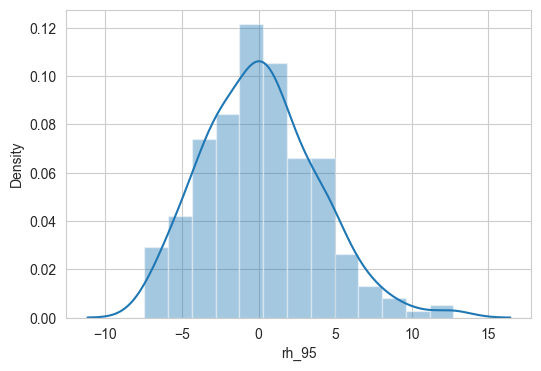

In [436]:
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error
%matplotlib inline
plt.rcParams.update({'figure.figsize':(6,4)})
y_pred = model.predict(X_test)
from sklearn.metrics import mean_absolute_error, mean_squared_error

print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))
sns.distplot(y_test - y_pred)


Mean Absolute Error: 2.6853967625195594
Root Mean Squared Error: 3.3027784010843013
MAPE: 0.3551880425225614


C:\Users\tanya\AppData\Local\Temp\ipykernel_27316\1883309535.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test - y_pred)


<Axes: xlabel='rh_95', ylabel='Density'>

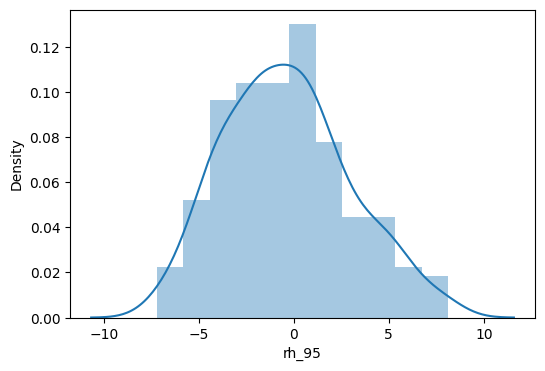

In [409]:
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error
%matplotlib inline
plt.rcParams.update({'figure.figsize':(6,4)})
y_pred = rf_random.predict(X_test)
from sklearn.metrics import mean_absolute_error, mean_squared_error

print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))
sns.distplot(y_test - y_pred)


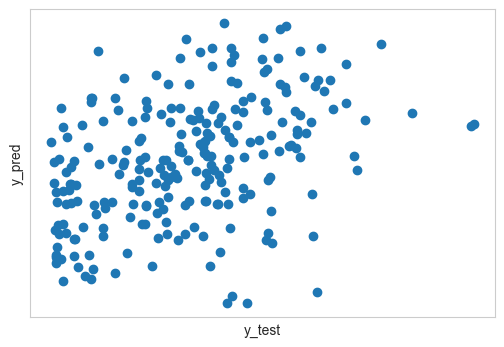

In [432]:
plt.scatter(y_test,y_pred) 
plt.xlabel('y_test'); plt.xticks([])
plt.ylabel('y_pred'); plt.yticks([])
plt.show() 

In [433]:

res = list(zip(y_test,y_pred))
for idx, (x,y) in enumerate(res):
    print(x,y)
    if idx ==30:
        break

7.210000038146973 8.249345737823914
3.700000047683716 5.352795198502373
8.40999984741211 8.231075084513533
15.960000038146973 9.976983615365917
7.989999771118164 8.50658331990228
4.440000057220459 6.785290657444231
6.090000152587891 8.816176083459402
2.1600000858306885 6.941219933818512
8.0 8.651286569014806
9.3100004196167 8.358933450685695
7.25 7.785507596181519
11.079999923706056 8.325049250452592
12.260000228881836 6.026457307727669
16.329999923706055 8.3607009976396
2.240000009536743 8.253949027544966
10.010000228881836 9.534411971721896
10.279999732971191 3.865724580637237
13.760000228881836 9.601695699247585
7.199999809265137 6.740541839242552
11.960000038146973 11.314086655614798
3.059999942779541 7.488839968215565
9.550000190734863 11.66241691675439
3.130000114440918 6.97232627678251
6.190000057220459 8.895317033271562
15.210000038146973 10.675442251073283
2.200000047683716 6.250968405924835
7.440000057220459 7.6332244065250485
17.65999984741211 11.760408797203032
10.460000038

## Testing 

In [12]:
from tqdm import tqdm
import os
import rasterio
testset = os.listdir('./da/adani_testSet')

# for imgs in tqdm(testset):
#     # gc.collect()
#     # if imgs not in done:
    
B1 = './da/adani_testSet/B1.tif'
B2 = './da/adani_testSet/B2.tif'
B3 = './da/adani_testSet/B3.tif'
B4 = './da/adani_testSet/B4.tif'
B5 = './da/adani_testSet/B5.tif'
B6 = './da/adani_testSet/B6.tif'
B7 = './da/adani_testSet/B7.tif'
B8 = './da/adani_testSet/B8.tif'
B8A = './da/adani_testSet/B8A.tif'
B9 = './da/adani_testSet/B9.tif'
B11 = './da/adani_testSet/B11.tif'
B12 = './da/adani_testSet/B12.tif'
gci = './da/adani_testSet/gci.tif'
gli = './da/adani_testSet/gli.tif'
ndvi = './da/adani_testSet/ndvi.tif'
slope = './da/adani_testSet/slope.tif'
elevation = './da/adani_testSet/elevation.tif'
forestCover = './da/adani_testSet/forestCover.tif'

with rasterio.open(B1) as dataset:
    B1_arr = dataset.read()

with rasterio.open(B2) as dataset:
    B2_arr = dataset.read()
    
with rasterio.open(B3) as dataset:
    B3_arr = dataset.read()

with rasterio.open(B4) as dataset:
    B4_arr = dataset.read()

with rasterio.open(B5) as dataset:
    B5_arr = dataset.read()

with rasterio.open(B6) as dataset:
    B6_arr = dataset.read()

with rasterio.open(B7) as dataset:
    B7_arr = dataset.read()

with rasterio.open(B8) as dataset:
    B8_arr = dataset.read()

with rasterio.open(B8A) as dataset:
    B8A_arr = dataset.read()

with rasterio.open(B9) as dataset:
    B9_arr = dataset.read()

with rasterio.open(B11) as dataset:
    B11_arr = dataset.read()

with rasterio.open(B12) as dataset:
    B12_arr = dataset.read()

with rasterio.open(gci) as dataset:
    gci_arr = dataset.read()

with rasterio.open(gci) as dataset:
    gli_arr = dataset.read()

with rasterio.open(ndvi) as dataset:
    ndvi_arr = dataset.read()

with rasterio.open(slope) as dataset:
    slope_arr = dataset.read()

with rasterio.open(elevation) as dataset:
    elevation_arr = dataset.read()

with rasterio.open(forestCover) as dataset:
    forestCover_arr = dataset.read()



In [ ]:
import gc
gc.collect()

799

In [13]:
imgs = os.listdir('./da/adani_testSet')
feat=[]
for i in imgs:
    feat.append(i.split('.')[0])

print(feat)
import gc
gc.collect()
all_feats =[B1_arr,B2_arr,B3_arr,B4_arr,B5_arr,B6_arr,B7_arr,B8_arr,B8A_arr,B9_arr,B11_arr,B12_arr,slope_arr,elevation_arr,gci_arr,ndvi_arr,gli_arr,forestCover_arr]
stacked_features = np.stack((all_feats),axis=1)



['B1', 'B11', 'B12', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'elevation', 'forestCover', 'gci', 'gli', 'ndvi', 'slope']


In [46]:
print(stacked_features.shape)

(1, 18, 3264, 24503)


In [47]:
# Reshape the array to have shape (18, -1) to combine the last two dimensions
reshaped_array = stacked_features.reshape(18, -1)

# Create a DataFrame from the reshaped array
df_test = pd.DataFrame(reshaped_array.T) 
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
batch_size = 10000
num_batches = int(len(df_test)/batch_size)
print(num_batches)

array_shape = (len(df_test),1)
empty_array = np.empty(array_shape)
start =0
end = batch_size
for i in tqdm(range(num_batches)):
    
    #try:
       # print(start,end)
    y_pred = rf_random.predict(df_test.iloc[start:end,:-1])
    empty_array[start:end] =y_pred.reshape(-1, 1) 
    start = end
    end = end+batch_size
    #except Exception as e:
        # print(e)
        # start = end
        # end = end+batch_size
        # continue
    # if i ==10:
    #     break
    


7997


100%|██████████| 7997/7997 [55:47<00:00,  2.39it/s]  


In [48]:
empty_array.shape

(79977792, 1)

In [49]:
empty_array.min()

0.0

In [17]:
df_test['TC'] = empty_array

In [50]:
vals  = empty_array.reshape(3264, 24503)

In [51]:
from rasterio.crs import CRS

# Replace with your actual 2D array

# Define the output file path
output_file = "tch.tif"  # Replace with your desired file path

# Define the CRS information

with rasterio.open(B9) as dataset:
    # B9_arr = dataset.read()
    crs = dataset.crs
    transform = dataset.transform
with rasterio.open(output_file, 'w', driver='GTiff', height=vals.shape[0], width=vals.shape[1], count=1, dtype=vals.dtype,crs=crs, transform=transform) as dst:
    dst.write(vals, 1)

In [44]:
fc = './da/adani_april/forestCover.tif'
b1 = './da/adani_april/B1.tif'
from tqdm import tqdm

with rasterio.open(b1) as im:
     image_data = im.read()
with rasterio.open(fc) as dataset:
        # Read the image data
        mask_data= dataset.read()
        
        for x in tqdm(range(mask_data.shape[1])):
            for y in range(mask_data.shape[2]):
                if mask_data[0][x][y]!=10:
                    #print(mask_data[0][x][y],image_data[0][x][y])
                    image_data[0][x][y]=np.nan

100%|██████████| 3264/3264 [03:34<00:00, 15.23it/s]


In [ ]:
for x in tqdm(range(image_data.shape[1])):
    for y in range(image_data.shape[2]):
        if image_data[0][x][y]!=np.nan:
            print(image_data[0][x][y])

In [17]:
import pandas as pd
df = pd.DataFrame(test_dict)
df.to_csv('./B1_2_11_12.csv',index = False)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'figure.figsize':(2,1)})

X = df[:int(len(df)/8)].copy()
X = X[['rh_95','B1_mean','B2_mean','B3_mean','B4_mean','B5_mean','B6_mean','B7_mean',\
       'B8_mean','B9_mean','B8A_mean','B11_mean','B12_mean','slope_mean',\
        'elevation_mean','gci_mean','ndvi_mean','gli_mean','forestMask']]

X = X.loc[X['forestMask'] == 10]

ind = ['B1_mean','B2_mean','B3_mean','B4_mean','B5_mean','B6_mean','B7_mean',\
       'B8_mean','B9_mean','B8A_mean','B11_mean','B12_mean','slope_mean',\
        'elevation_mean','gci_mean','ndvi_mean','gli_mean']
for i in ind:
    print(i)
    plt.figure()
   
    plt.scatter(X[i],X['rh_95'])
    plt.show()

## Polynomial regression

In [51]:
# Import function to create training and test set splits
from sklearn.model_selection import train_test_split
# Import function to automatically create polynomial features! 
from sklearn.preprocessing import PolynomialFeatures
# Import Linear Regression and a regularized regression function
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
# Finally, import function to make a machine learning pipeline
from sklearn.pipeline import make_pipeline

In [60]:
# Alpha (regularization strength) of LASSO regression
lasso_eps = 0.01
lasso_nalpha=20
lasso_iter=5000
# Min and max degree of polynomials features to consider
degree_min = 6
degree_max = 10
# Test/train split

X = df[:int(len(df)/2)].copy()
X = X[['rh_95','B1_mean','B2_mean','B3_mean','B4_mean','B5_mean','B6_mean','B7_mean',\
       'B8_mean','B9_mean','B8A_mean','B11_mean','B12_mean','slope_mean',\
        'elevation_mean','gci_mean','ndvi_mean','gli_mean','forestMask']]

X = X.loc[X['forestMask'] == 10]
y = X.pop('rh_95')

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)
print(len(X_train),len(X_test))
#Make a pipeline model with polynomial transformation and LASSO regression with cross-validation, run it for increasing degree of polynomial (complexity of the model)
# for degree in range(degree_min,degree_max+1):
#     model = LassoCV(eps=lasso_eps,n_alphas=lasso_nalpha,max_iter=lasso_iter,cv=5)
#     model.fit(X_train,y_train)
#     test_pred = np.array(model.predict(X_test))
#     RMSE=np.sqrt(np.sum(np.square(test_pred-y_test)))
#     print(RMSE)
#     test_score = model.score(X_test,y_test)
    # print(test_score)

3772 943


In [ ]:
X.xolumns

In [81]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(3,include_bias=False)


X = df[:int(len(df)/2)].copy()
X = X[['rh_95','B1_mean','B2_mean','B3_mean','B4_mean','B5_mean','B6_mean','B7_mean',\
       'B8_mean','B9_mean','B8A_mean','B11_mean','B12_mean','slope_mean',\
        'elevation_mean','gci_mean','ndvi_mean','gli_mean','forestMask']]

X = X.loc[X['forestMask'] == 10]
forest= X.pop('forestMask')
y = X.pop('rh_95')
X_poly = poly.fit_transform(X)
df_poly = pd.DataFrame(X_poly)

new_cols = []
for i in df_poly.columns:
    new_cols.append(str(i))

df_poly.columns = new_cols


# y.rename(columns = {'test':'TEST'}, inplace = True)
df_poly.head()
# X_poly_feature_name = poly.get_feature_names(['Feature'+str(l) for l in range(1,6)])
# print(X_poly_feature_name)
# print(len(X_poly_feature_name))

0         1         2         3         4         5         6  \
0  0.150200  0.161513  0.192875  0.207583  0.255088  0.290438  0.312675   
1  0.151869  0.163446  0.192738  0.212219  0.259546  0.296581  0.318319   
2  0.152508  0.165908  0.198588  0.216654  0.271065  0.313173  0.337365   
3  0.152454  0.159981  0.190462  0.210350  0.273138  0.321938  0.344562   
4  0.152827  0.163373  0.199115  0.216104  0.272112  0.324531  0.349792   

          7         8         9  ...      1129      1130      1131      1132  \
0  0.319638  0.340017  0.334992  ...  0.329644  0.106776  0.009949  0.034586   
1  0.326312  0.356796  0.347485  ...  0.444962  0.130387  0.007275  0.038208   
2  0.355815  0.361142  0.366035  ...  0.621992  0.182230  0.013674  0.053390   
3  0.359638  0.372865  0.371904  ...  0.775722  0.231410  0.012697  0.069033   
4  0.369208  0.373723  0.378962  ...  0.664754  0.199886  0.015850  0.060104   

       1133      1134      1135      1136      1137      1138  
0  0.003222  0.000300  0.011203  0.001044  0.000097  0.000009  
1  0.002132  0.000119  0.011196  0.000625  0.000035  0.000002  
2  0.004006  0.000301  0.015642  0.001174  0.000088  0.000007  
3  0.003788  0.000208  0.020594  0.001130  0.000062  0.000003  
4  0.004766  0.000378  0.018073  0.001433  0.000114  0.000009  

[5 rows x 1139 columns]

In [82]:
# df_poly['y']=y
X_train=df_poly
y_train=y
y.isna().sum()



0

In [83]:

poly = LinearRegression()
model_poly=poly.fit(X_train,y_train)
y_poly = poly.predict(X_train)
RMSE_poly=np.sqrt(np.sum(np.square(y_poly-y_train)))
print("Root-mean-square error of simple polynomial model:",RMSE_poly)

Root-mean-square error of simple polynomial model: 242.5065869363027


In [86]:
from sklearn.linear_model import LassoCV
model1 = LassoCV(cv=10,verbose=0,eps=0.001,n_alphas=100, tol=0.0001,max_iter=5000)
model1.fit(X_train,y_train)
y_pred1 = np.array(model1.predict(X_train))
RMSE_1=np.sqrt(np.sum(np.square(y_pred1-y_train)))
print("Root-mean-square error of Metamodel:",RMSE_1)
model1.score(X_train,y_train)

Root-mean-square error of Metamodel: 304.7652435415154


0.08246817438971499

## Misc. experimentations

In [359]:
df


coord       pixelVal  rh_95  rh_99  \
0       (22.49571875261186, 73.95715244626408)  (3262, 13437)  10.54  11.33   
1       (22.49611598652905, 73.95750292595079)  (3258, 13441)   5.72   6.54   
2      (22.496508403918142, 73.95784563048663)  (3254, 13444)   9.68  10.62   
3       (22.496907259806722, 73.9581987101031)  (3249, 13448)   5.64   6.69   
4       (22.49731037477882, 73.95855865602469)  (3245, 13452)  11.85  12.71   
...                                        ...            ...    ...    ...   
17576  (22.786964871836926, 73.71392040683092)    (20, 10729)   3.02   7.36   
17577  (22.787361851814218, 73.71427537607269)    (16, 10733)   2.16   3.06   
17578  (22.787758868203415, 73.71463048111421)    (11, 10737)   3.17   6.72   
17579  (22.788156127991385, 73.71498595580813)     (7, 10741)   7.06   8.78   
17580   (22.78855345392674, 73.71534157493427)     (2, 10745)   5.68   8.33   

       degrade_flag  quality_flag   B1_mean  B1_median   B1_50p   B1_75p  ...  \
0                80             0  0.150200    0.15015  0.15015  0.15030  ...   
1                80             0  0.151869    0.15200  0.15200  0.15200  ...   
2                80             0  0.152508    0.15255  0.15255  0.15255  ...   
3                80             0  0.152454    0.15285  0.15285  0.15285  ...   
4                80             0  0.152827    0.15285  0.15285  0.15285  ...   
...             ...           ...       ...        ...      ...      ...  ...   
17576            80             1  0.135542    0.13445  0.13445  0.13800  ...   
17577            80             1  0.139792    0.14050  0.14050  0.14050  ...   
17578            80             1  0.146281    0.15025  0.15025  0.15025  ...   
17579            80             1  0.150119    0.15025  0.15025  0.15025  ...   
17580            80             1  0.153350    0.15335  0.15335  0.15335  ...   

       ndvi_mean  ndvi_median  ndvi_50p  ndvi_75p  ndvi_95p  slope_mean  \
0       0.223757     0.222421  0.222421  0.241848  0.255036    8.212587   
1       0.223711     0.211850  0.211850  0.249911  0.265846   11.750763   
2       0.250090     0.242308  0.242308  0.295903  0.317150    4.689776   
3       0.274102     0.259645  0.259645  0.293420  0.397511   15.038361   
4       0.262427     0.264690  0.264690  0.297269  0.324292   19.066711   
...          ...          ...       ...       ...       ...         ...   
17576   0.268190     0.258472  0.258472  0.296537  0.332906    2.355754   
17577   0.255658     0.274254  0.274254  0.281175  0.283521    2.747392   
17578   0.316831     0.330588  0.330588  0.388460  0.399856    1.568800   
17579   0.222101     0.207637  0.207637  0.259017  0.282212    4.640206   
17580   0.164263     0.148263  0.148263  0.178891  0.223063    1.911152   

       slope_median  slope_50p  slope_75p  slope_95p  
0          8.347988   8.347988   8.890456  10.517859  
1         11.668093  11.668093  13.237470  13.237470  
2          4.093288   4.093288   5.006632   6.572777  
3         16.923151  16.923151  16.923151  17.543848  
4         18.541391  18.541391  21.150249  21.150249  
...             ...        ...        ...        ...  
17576      2.109262   2.109262   2.109262   3.951571  
17577      2.780288   2.780288   2.956126   3.308952  
17578      1.368062   1.368062   1.368062   3.308953  
17579      4.771455   4.771455   4.771459   4.815087  
17580      0.927410   0.927410   3.154172   3.154172  

[45718 rows x 92 columns]

In [360]:
for band in band_col.keys():
    if band!= 'forestCover':
        for metric in band_col[band].keys():
            df[band+'_'+metric] = band_col[band][metric]
    else:
        df['forestMask'] = band_col['forestCover']

NameError: name 'band_col' is not defined

In [249]:
len(df.columns)

95

In [250]:
df

coord      pixelVal      rh_95   
0      (20.863128700275038, 80.0747267014715)       (3, 99)   2.430000  \
1       (20.86272723555814, 80.0750705485513)      (8, 103)   5.720000   
2     (20.862325880675826, 80.07541432822951)     (12, 107)   2.990000   
3     (20.861924355619617, 80.07575820908367)     (17, 111)   4.480000   
4     (20.861522929800948, 80.07610203302839)     (21, 115)   2.350000   
...                                       ...           ...        ...   
4232  (20.637260788732995, 80.51464917257036)  (2518, 4996)  18.629999   
4233   (20.637663050002306, 80.5149933602614)  (2513, 5000)   6.620000   
4234  (20.638065224303816, 80.51533745556237)  (2509, 5004)  16.389999   
4235   (20.638467080669606, 80.5156811512248)  (2504, 5008)   6.470000   
4236  (20.638867827410227, 80.51602339649341)  (2500, 5012)  10.770000   

          rh_99   B1_mean  B1_median   B1_50p   B1_75p   B1_95p  B11_mean   
0      2.990000  0.072092    0.07320  0.07320  0.07320  0.07320  0.198962  \
1      6.580000  0.073200    0.07310  0.07310  0.07310  0.07364  0.210469   
2      3.700000  0.074915    0.07430  0.07430  0.07660  0.07660  0.222208   
3      5.720000  0.076662    0.07660  0.07660  0.07690  0.07690  0.216815   
4      2.950000  0.075700    0.07570  0.07570  0.07570  0.07570  0.208085   
...         ...       ...        ...      ...      ...      ...       ...   
4232  19.910000  0.039400    0.03940  0.03940  0.03940  0.03940  0.146685   
4233   8.230000  0.040708    0.04065  0.04065  0.04065  0.04095  0.164446   
4234  18.370001  0.042569    0.04330  0.04330  0.04330  0.04374  0.176254   
4235   7.780000  0.044662    0.04440  0.04440  0.04525  0.04525  0.188935   
4236  11.970000  0.045631    0.04580  0.04580  0.04580  0.04580  0.180827   

      ...  savi_mean  savi_median  savi_50p  savi_75p  savi_95p  slope_mean   
0     ...   0.199654     0.200551  0.200551  0.214394  0.224870    3.022187  \
1     ...   0.203623     0.206244  0.206244  0.224497  0.243964    0.713511   
2     ...   0.193223     0.186897  0.186897  0.206756  0.222219    1.209474   
3     ...   0.199476     0.197100  0.197100  0.203396  0.226566    2.703735   
4     ...   0.198802     0.194991  0.194991  0.217864  0.238420    2.272729   
...   ...        ...          ...       ...       ...       ...         ...   
4232  ...   0.296650     0.291710  0.291710  0.308923  0.330355    2.301708   
4233  ...   0.254396     0.254962  0.254962  0.262338  0.271311    1.621628   
4234  ...   0.285189     0.285149  0.285149  0.303343  0.329217    2.064845   
4235  ...   0.251823     0.252830  0.252830  0.261998  0.273071    4.390546   
4236  ...   0.282080     0.280732  0.280732  0.302359  0.311357    3.231402   

      slope_median  slope_50p  slope_75p  slope_95p  
0         2.780288   2.780288   2.780288   4.731700  
1         0.000000   0.000000   0.992467   2.560324  
2         1.358210   1.358210   2.714893   3.030476  
3         1.854334   1.854334   4.373703   4.373703  
4         1.358205   1.358205   3.834707   3.834707  
...            ...        ...        ...        ...  
4232      1.854334   1.854334   1.854334   4.858247  
4233      2.102202   2.102202   2.102202   2.346419  
4234      2.187385   2.187385   2.187385   2.187385  
4235      4.743530   4.743530   4.743530   4.743530  
4236      3.500130   3.500130   3.500130   3.779584  

[4237 rows x 95 columns]

In [251]:
df.to_csv('./test_dfall.csv')

In [357]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from catboost import CatBoostRegressor




In [358]:
X = df.copy()
X = X.drop(['coord','pixelVal','rh_99'],axis = 1)
X = X.loc[X['forestMask'] == 10]
y = X.pop("rh_95")

# Train and score baseline model
# baseline = CatBoostRegressor(iterations=200,
#                           learning_rate=1,
#                           depth=7)

baseline = RandomForestRegressor(criterion="absolute_error", random_state=0)
baseline_score = cross_val_score(
    baseline, X, y,cv = 5, scoring="neg_mean_absolute_error"
)

print(baseline_score)
baseline_score = -1 * baseline_score.mean()

print(f"MAE Baseline Score: {baseline_score:.4}")#2.772 for rh_95

[-3.42755339 -3.56864711 -3.4136886  -3.20988378 -3.60269433]
MAE Baseline Score: 3.444


<Axes: >

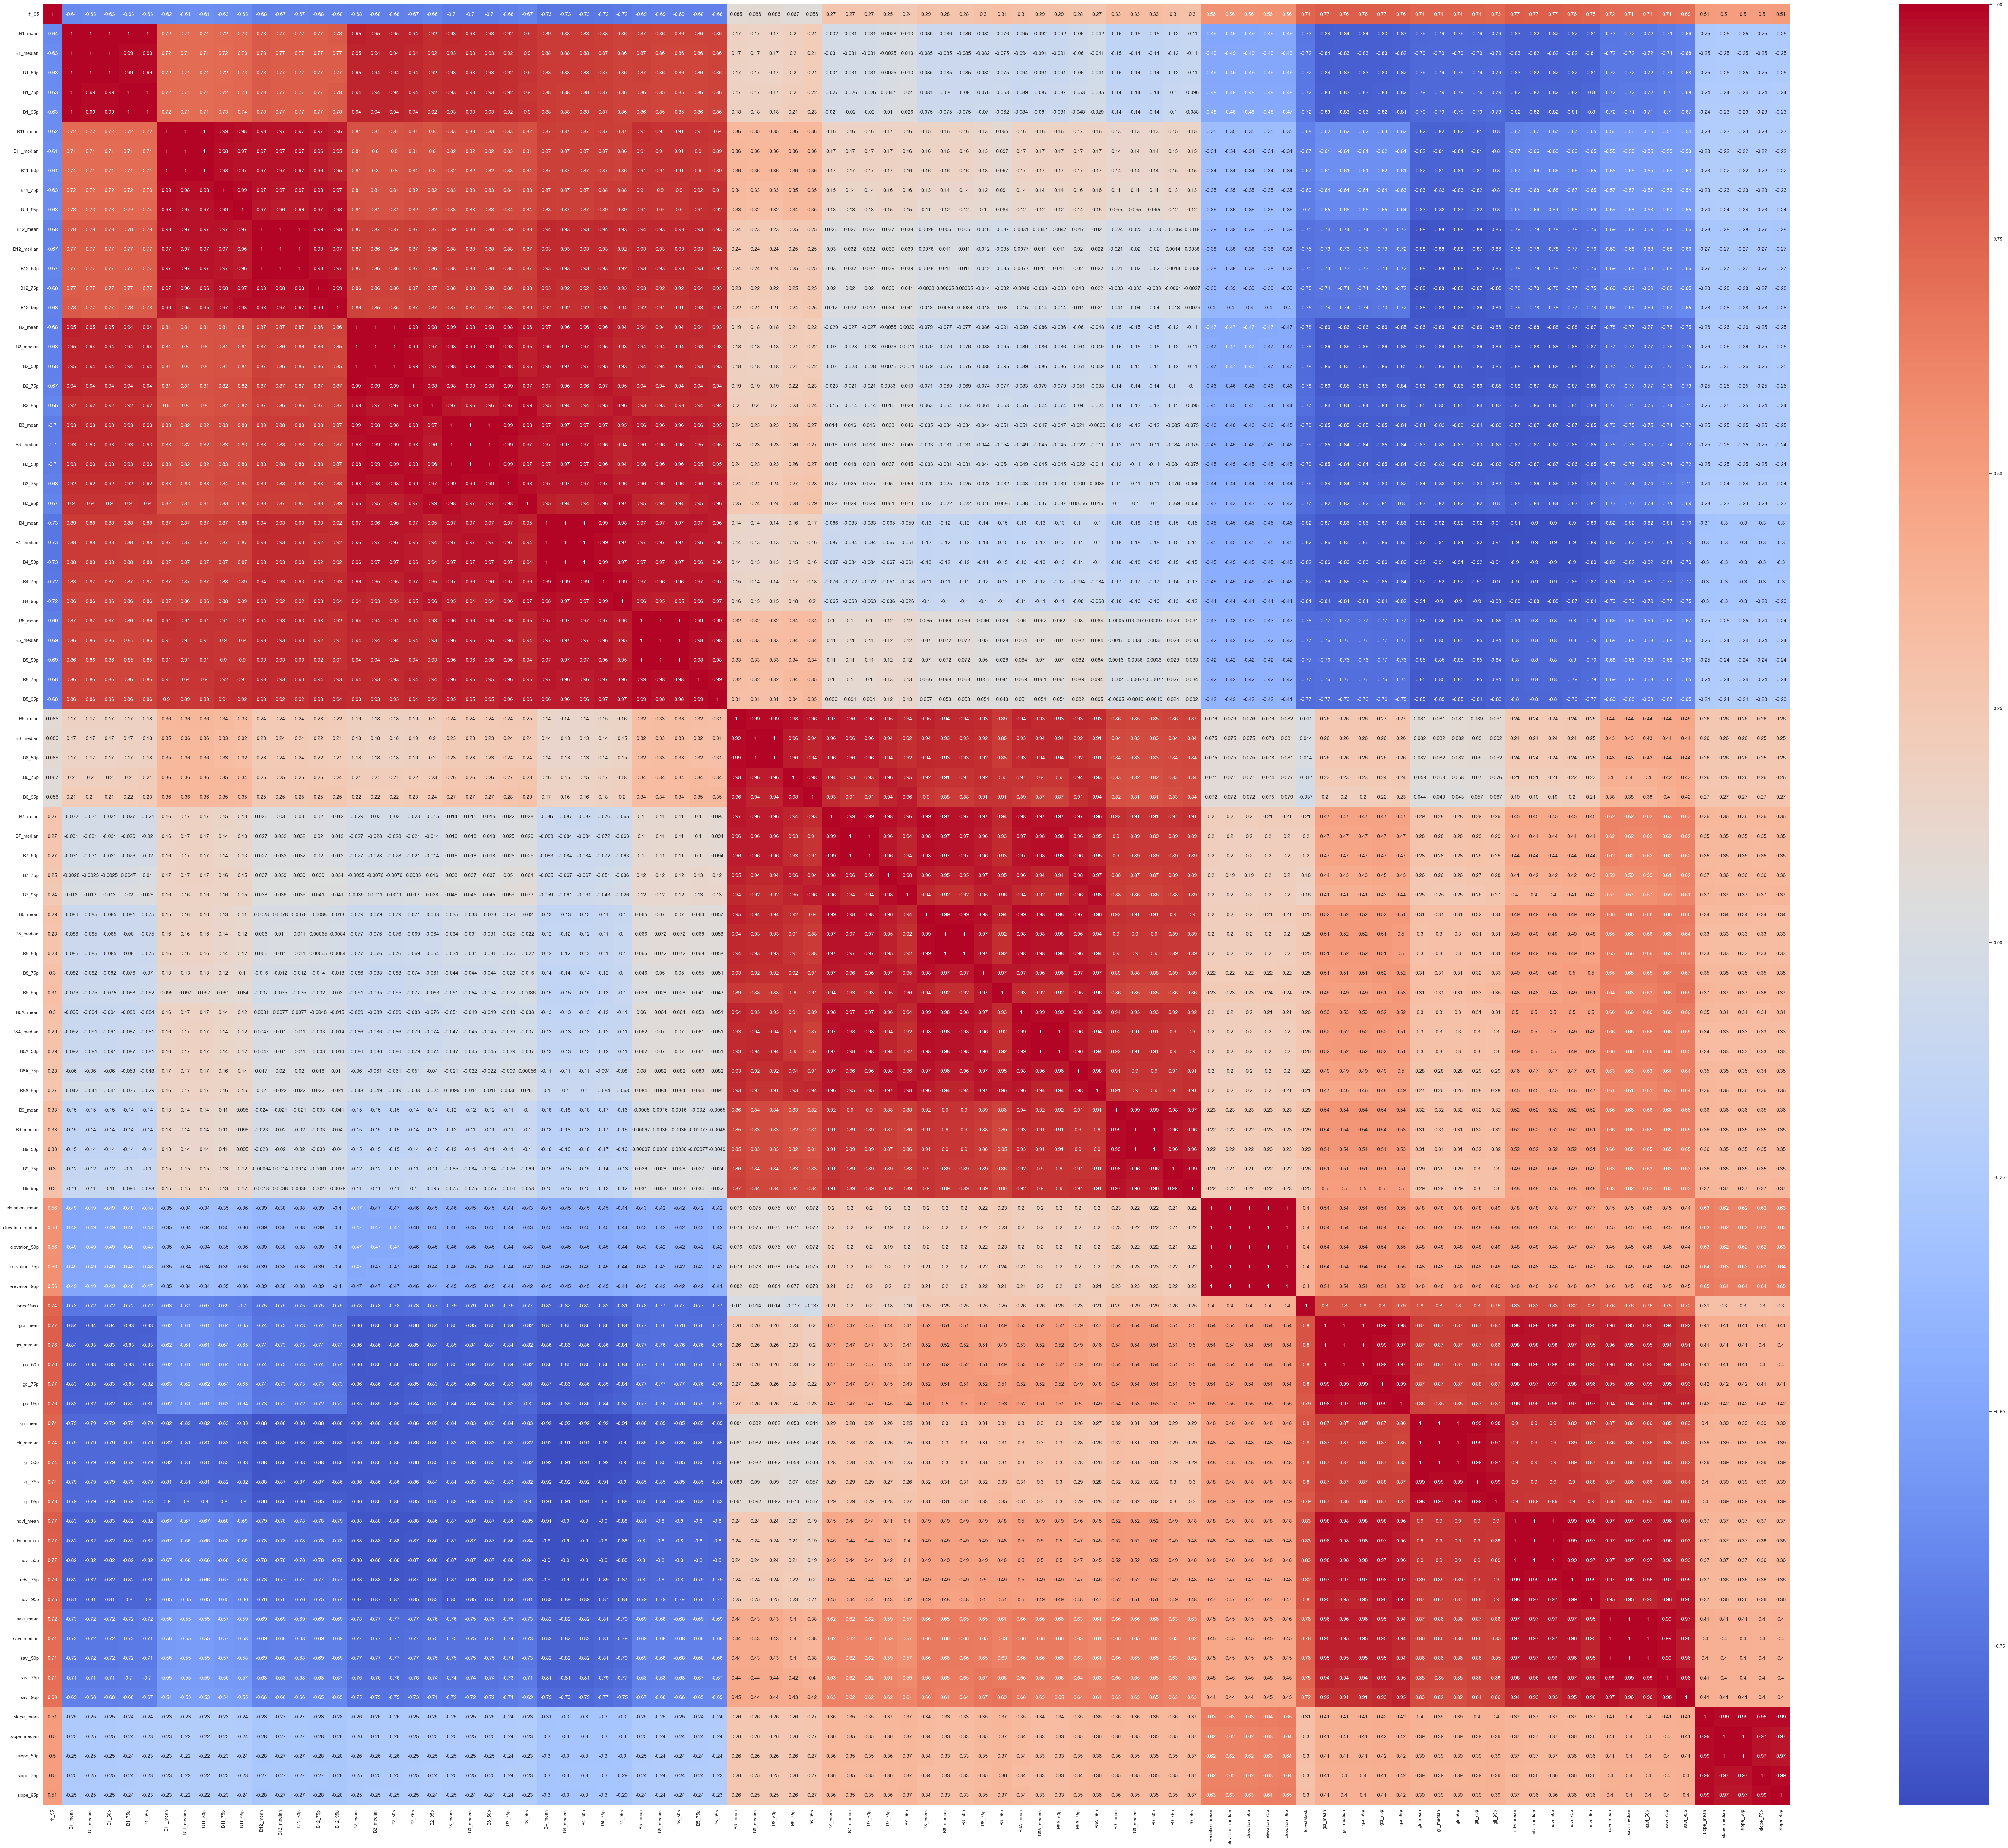

In [210]:
import seaborn as sns
sns.set(rc = {'figure.figsize':(94,78)})
df_eda = df.drop(['coord','pixelVal'],axis = 1)
sns.heatmap(df_eda.corr(), annot = True, fmt='.2g',cmap= 'coolwarm')


In [211]:
corr = df_eda.drop("rh_95", axis=1).apply(lambda x: x.corr(df_eda.rh_95))

In [212]:
corr.values

array([-0.63661526, -0.63407265, -0.63407265, -0.62925283, -0.62652353,
       -0.62051665, -0.6142727 , -0.6142727 , -0.62695401, -0.63305711,
       -0.67797893, -0.6720472 , -0.6720472 , -0.67626302, -0.67792851,
       -0.68109713, -0.67976842, -0.67976842, -0.67312495, -0.65806637,
       -0.69864656, -0.69679276, -0.69679276, -0.68477689, -0.66673002,
       -0.7319646 , -0.7280338 , -0.7280338 , -0.72431425, -0.71500773,
       -0.69276744, -0.68594376, -0.68594376, -0.68227625, -0.68051082,
        0.08493496,  0.08600781,  0.08600781,  0.06661674,  0.05598164,
        0.27122166,  0.26862496,  0.26862496,  0.25204845,  0.24394807,
        0.28813839,  0.28336409,  0.28336409,  0.30133484,  0.31362114,
        0.29925466,  0.2945649 ,  0.2945649 ,  0.27756741,  0.27080898,
        0.32963746,  0.32694667,  0.32694667,  0.30326205,  0.30055262,
        0.55582959,  0.55604101,  0.55604101,  0.55758628,  0.55973898,
        0.74226184,  0.76595085,  0.76318935,  0.76318935,  0.76

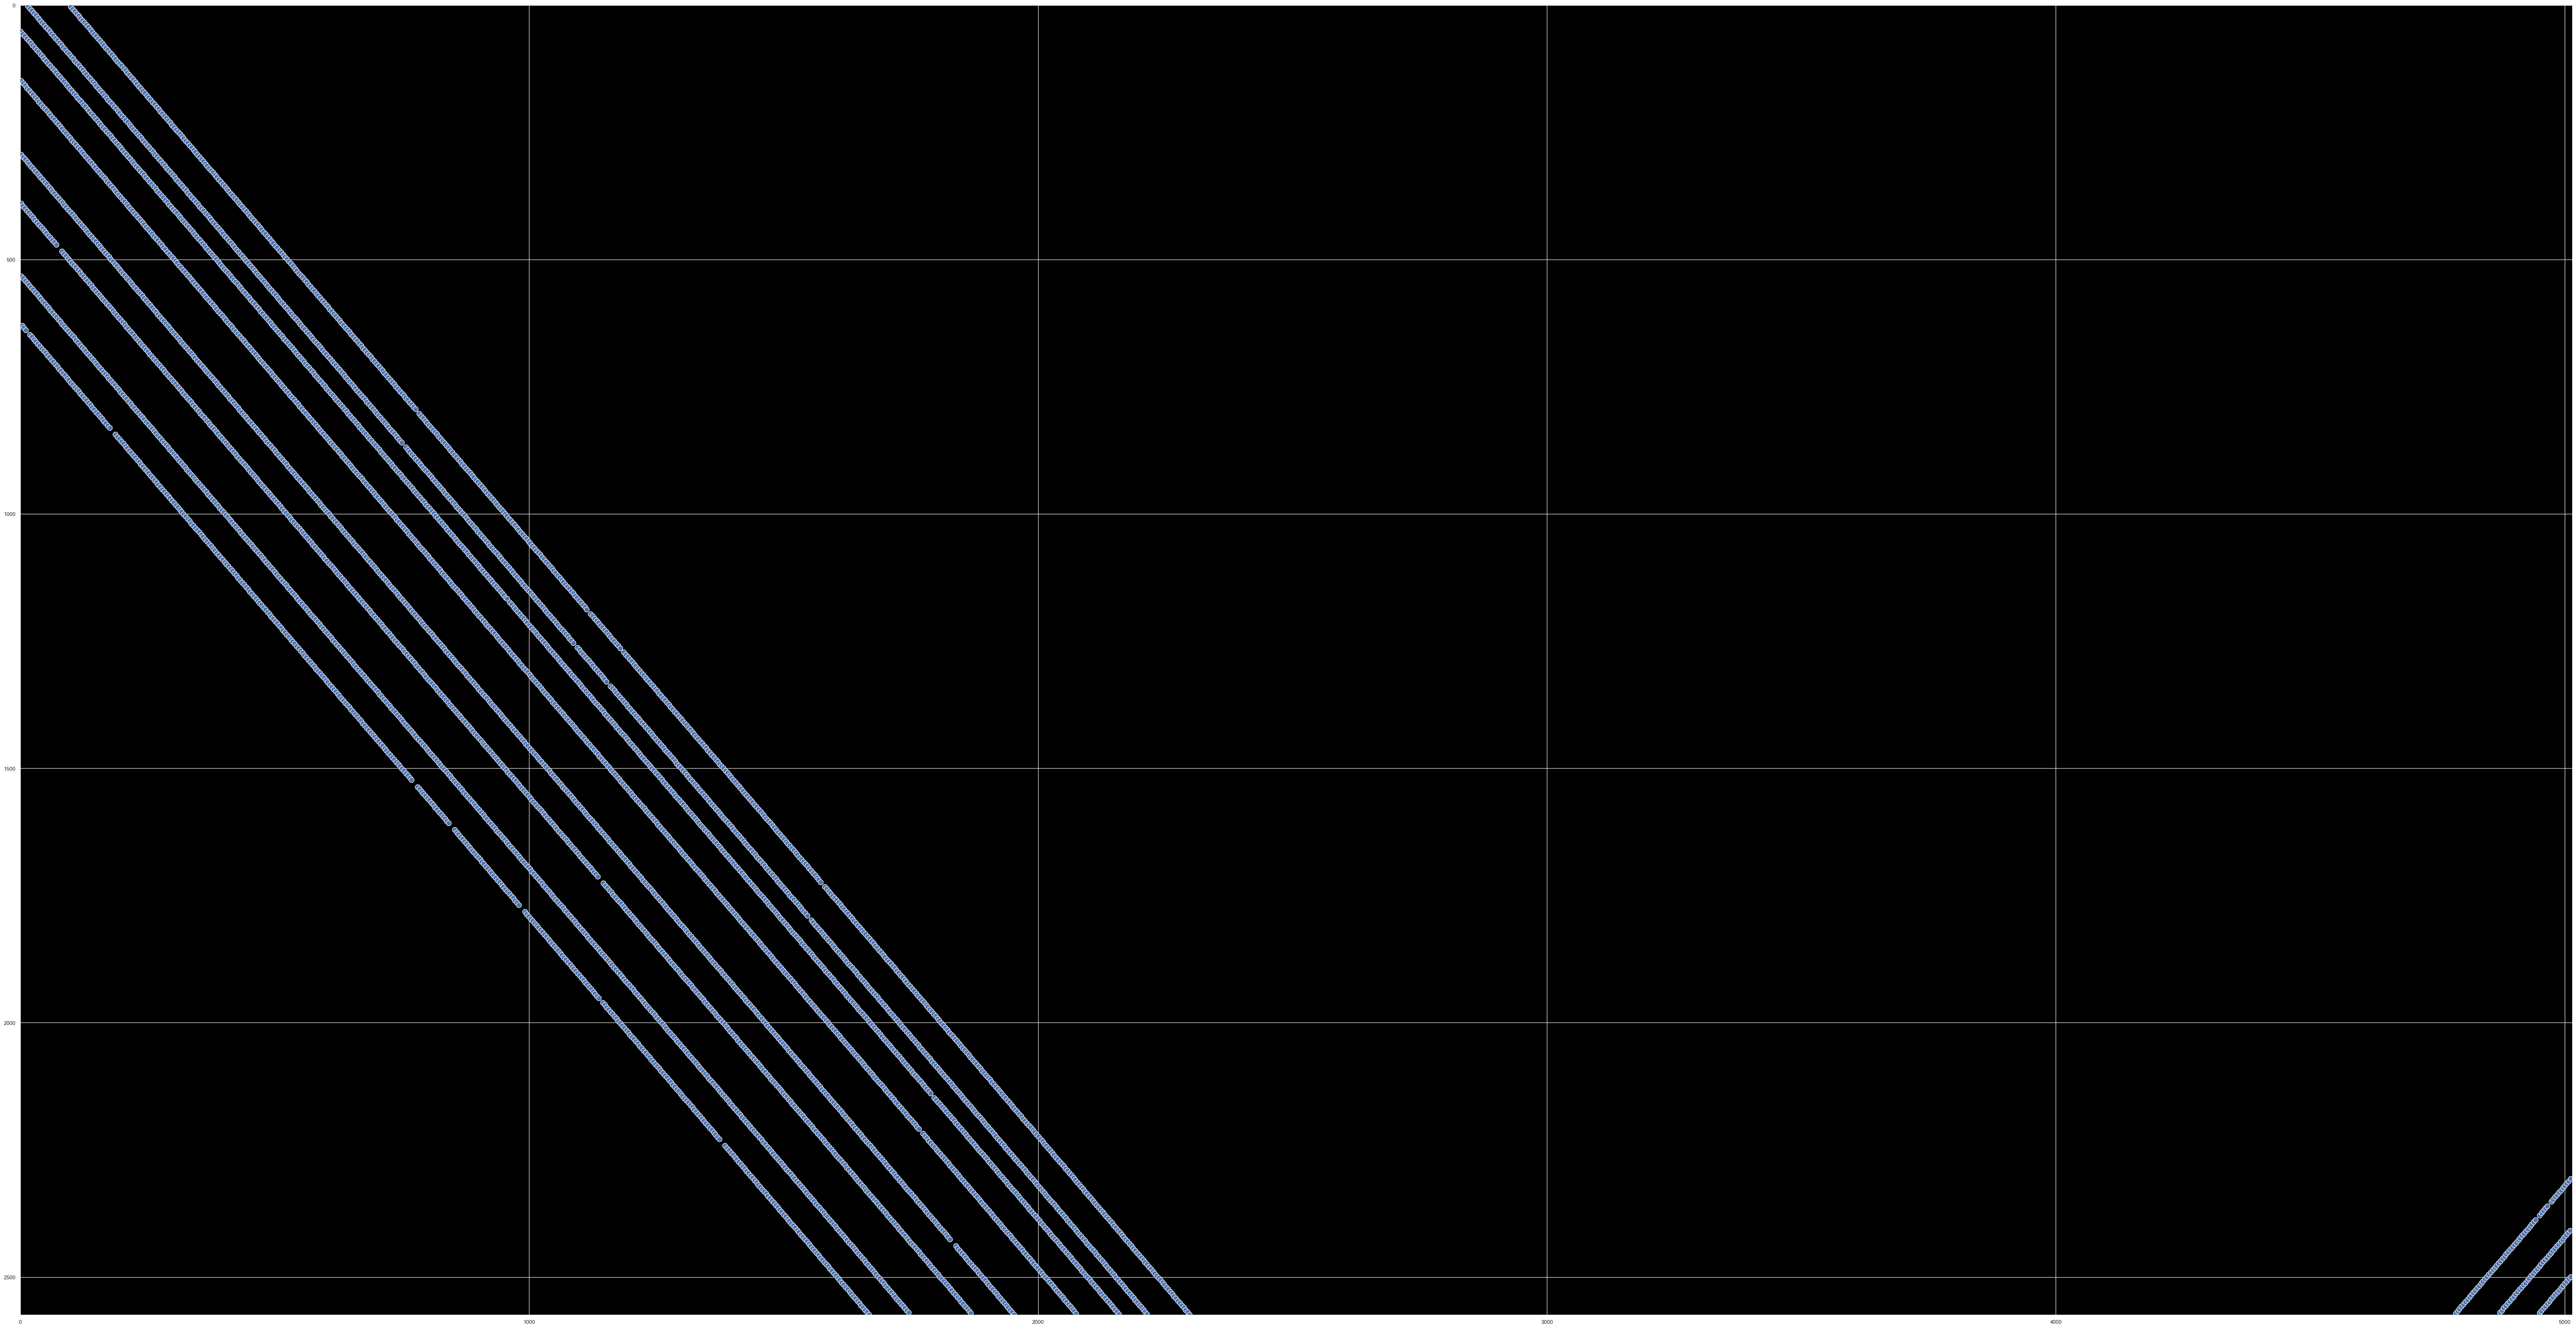

In [213]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Circle

# Get an example image
import matplotlib.cbook as cbook
image_file ='./GEE_Folder_2/B1.tif'
img = plt.imread(image_file)

# Make some example data
x = np.random.rand(5)*img.shape[1]
y = np.random.rand(5)*img.shape[0]

# Create a figure. Equal aspect so circles look circular
fig,ax = plt.subplots(1)
ax.set_aspect('equal')

# Show the image
ax.imshow(img)

# Now, loop through coord arrays, and create a circle at each x,y pair
# for xx,yy in zip(x,y):

# Now, loop through coord arrays, and create a circle at each x,y pair
for xx in zip(rowcols):
    circ = Circle((xx[0][1],xx[0][0]),5)
    ax.add_patch(circ)


# Show the image
plt.show()